In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os


In [2]:
dirname='/kaggle/input/affectnet-training-data/'
data=pd.read_csv(dirname+'labels.csv')

In [3]:
data.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28175 entries, 0 to 28174
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  28175 non-null  int64  
 1   pth         28175 non-null  object 
 2   label       28175 non-null  object 
 3   relFCs      28175 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 880.6+ KB


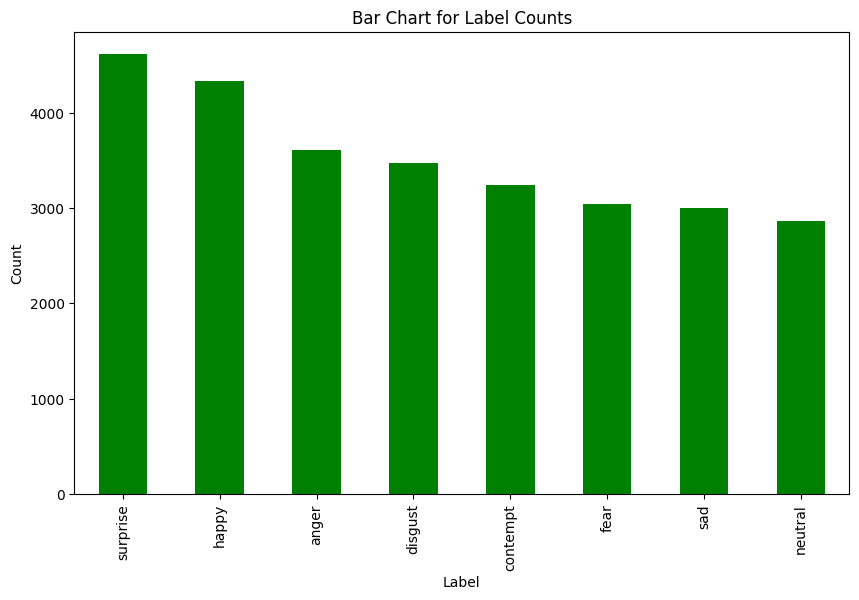

In [5]:
import matplotlib.pyplot as plt
# Count occurrences of each label
label_counts = data['label'].value_counts()

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='green')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Bar Chart for Label Counts')
plt.show()


In [6]:
pwd

'/kaggle/working'

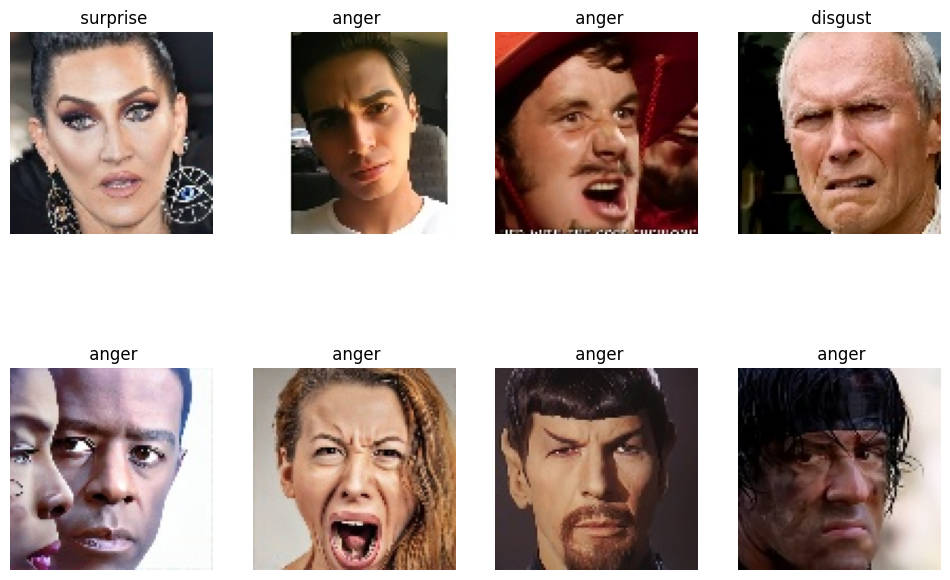

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Specifying the path to your image file

def image_show(i):
    pth=data.iloc[i,1]
    image_path = '/kaggle/input/affectnet-training-data/'+pth
    img = mpimg.imread(image_path)
    return img,data.iloc[i,2]

# Displaying the first 8 images from the file
i=8
num_cols=int(i/2)
num_rows=int(i/num_cols)+i%2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0,i):
    row = i // num_cols
    col = i % num_cols
    img_path,title=image_show(i)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f' {title}')
    axes[row, col].axis('off')

In [8]:
# Extract features (image paths) and labels
X = data['pth'].values
y = data['label'].values

In [9]:
import cv2
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

def preprocess_image(image_path):
    img = cv2.imread(dirname+image_path)
    #Converting image to grey
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Resizing here not required as all image is 96*96 pixel
    img_resized = cv2.resize(img_gray, (96, 96))
#     Normalizing pixel from 0 to 1 range
    img_normalized = img_resized / 255.0
    return img_normalized


X_preprocessed=np.array([preprocess_image(image_path) for image_path in X])

# Labeling the data
le = LabelEncoder()
y_preprocessed = to_categorical(le.fit_transform(y))


In [10]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42, stratify=y)


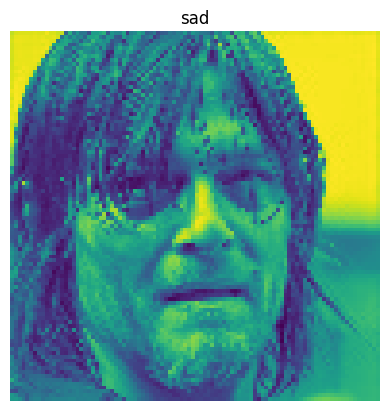

In [11]:
# choose a random image index
idx = np.random.randint(len(X))

# display the image and its corresponding label from arrays
plt.imshow(X_preprocessed[idx])
plt.title(y[idx])
plt.axis('off')  # remove the grid
plt.show()

In [12]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import platform
from keras.optimizers import Adam

# create model structure
model = Sequential()

input_shape=(96, 96, 1)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape= input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
#Number of class
num_class= len(np.unique(y))
model.add(Dense(num_class, activation='softmax'))

# Compile the model    

model.compile(optimizer=Adam(learning_rate=0.001), 
          loss='categorical_crossentropy', 
          metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 92, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 46, 46, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 128)       0         
 g2D)                                                   

In [13]:
num_epochs=10
batch_size=64
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)
# model.save('model_2.h5')


Epoch 1/10
282/282 [==============================] - 645s 2s/step - loss: 1.9962 - accuracy: 0.2126 - val_loss: 1.7095 - val_accuracy: 0.3707
Epoch 2/10
282/282 [==============================] - 648s 2s/step - loss: 1.6285 - accuracy: 0.3926 - val_loss: 1.4674 - val_accuracy: 0.4605
Epoch 3/10
282/282 [==============================] - 654s 2s/step - loss: 1.4515 - accuracy: 0.4541 - val_loss: 1.3565 - val_accuracy: 0.4973
Epoch 4/10
282/282 [==============================] - 657s 2s/step - loss: 1.3287 - accuracy: 0.5069 - val_loss: 1.2579 - val_accuracy: 0.5366
Epoch 5/10
282/282 [==============================] - 653s 2s/step - loss: 1.2273 - accuracy: 0.5464 - val_loss: 1.2042 - val_accuracy: 0.5555
Epoch 6/10
282/282 [==============================] - 645s 2s/step - loss: 1.1542 - accuracy: 0.5726 - val_loss: 1.1675 - val_accuracy: 0.5532
Epoch 7/10
282/282 [==============================] - 653s 2s/step - loss: 1.0820 - accuracy: 0.5988 - val_loss: 1.1641 - val_accuracy: 0.5632

In [14]:
# save model structure in jason file
model_json = model.to_json()
with open("/kaggle/working/model_json.json", "w") as json_file:
    json_file.write(model_json)

# save trained model weight in .h5 file
model.save_weights('/kaggle/working/model_weight.h5')

<Axes: >

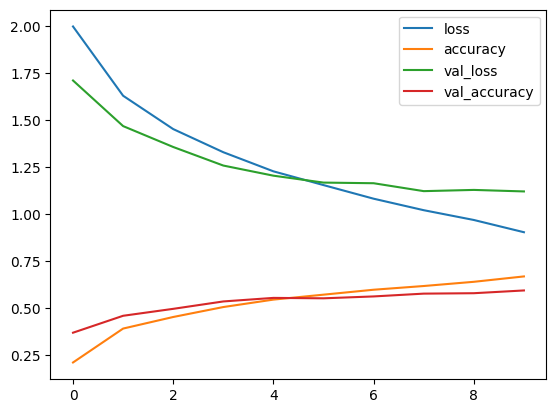

In [15]:
pd.DataFrame(history.history).plot()

**Load Model**

In [16]:
label_mapping={0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

177/177 [==============================] - 48s 268ms/step
      Label  Precision    Recall  F1-score       AUC
0     anger   0.620035  0.497230  0.551883  0.901666
1  contempt   0.537967  0.644068  0.586255  0.922852
2   disgust   0.545614  0.448127  0.492089  0.860684
3      fear   0.642715  0.528736  0.580180  0.920985
4     happy   0.798056  0.852364  0.824317  0.978121
5   neutral   0.451039  0.531469  0.487961  0.879601
6       sad   0.450746  0.504174  0.475965  0.867370
7  surprise   0.605544  0.615385  0.610425  0.905840
8   Overall   0.581464  0.577694  0.576134  0.904274


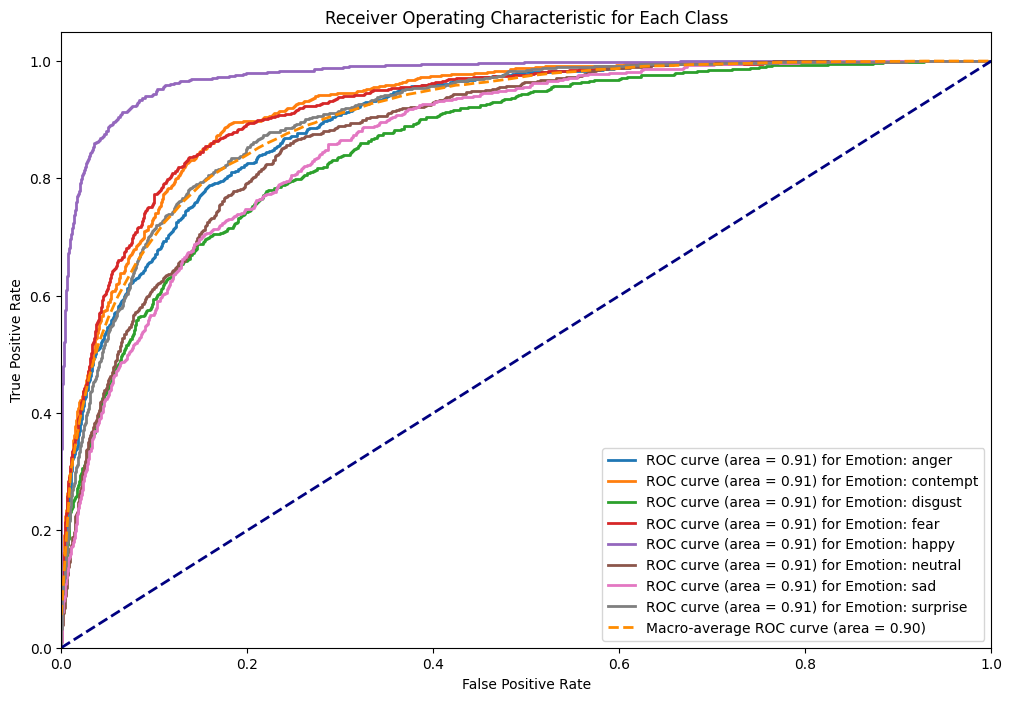

In [17]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score

y_pred_prob=model.predict(X_test)
# Convert probabilities to binary predictions
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Convert y_test to binary labels
y_true_labels = np.argmax(y_test, axis=1)

# List to store individual precision, recall, and F1-score values for each class
class_metrics = []

# List to store individual AUC values and ROC curves for each class
roc_curves = []


for i in range(8):
    # Convert predicted and true labels to binary labels
    y_pred_binary = (y_pred_labels == i)
    y_true_binary = (y_true_labels == i)
    
    # Calculate precision, recall, and F1-score
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)
    
    # ROC curve calculation
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, label_mapping[i]))
    
    # Store metrics in a dictionary
    class_metrics.append({
        'Label': label_mapping[i],
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc
    })


    
# Compute and plot macro-average ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_curves], axis=0)
macro_auc = auc(mean_fpr, mean_tpr)




# Calculate overall precision, recall, and F1-score
overall_precision = precision_score(y_true_labels, y_pred_labels, average='macro')
overall_recall = recall_score(y_true_labels, y_pred_labels, average='macro')
overall_f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

class_metrics.append({
    'Label': 'Overall',
    'Precision': overall_precision,
    'Recall': overall_recall,
    'F1-score': overall_f1,
    'AUC': macro_auc
})


# Create a Pandas DataFrame from the list of metrics
metrics_df = pd.DataFrame(class_metrics)

# Optionally, print the metrics table
print(metrics_df)


# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
lw = 2

    
for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = {:.2f}) for Emotion: {}'.format(roc_auc, label))

plt.plot(mean_fpr, mean_tpr, color='darkorange', linestyle='--', linewidth=2, label='Macro-average ROC curve (area = {:.2f})'.format(macro_auc))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc='lower right')
plt.show()

**Checking Wrong Image**

In [18]:
mismatch_index=[]
for i in range(0,len(y_true_labels)):
    if y_true_labels[i]!=y_pred_labels[i]:
        mismatch_index.append(i)

In [19]:
def pred_vs_actual_label(i):
    i=mismatch_index[i]
    img_array=X_test[i]
    img_array = (img_array * 255).astype(np.uint8)
    pred_label=label_mapping[y_pred_labels[i]]
    actual_label=label_mapping[y_true_labels[i]]
    return img_array,pred_label,actual_label

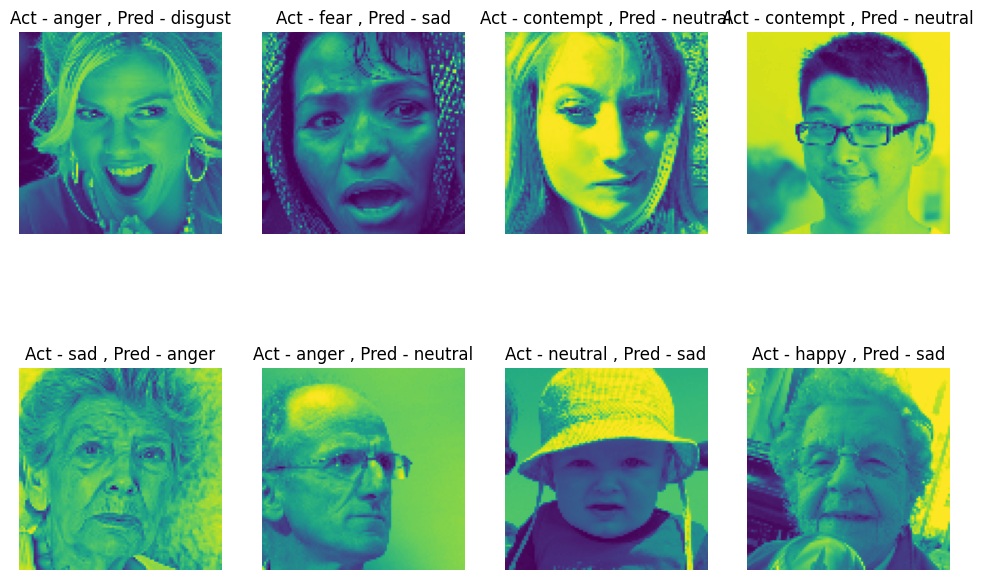

In [20]:

# Displaying the random 8 wrong images from the file
i=8
num_cols=int(i/2)
num_rows=int(i/num_cols)+i%2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0,i):
    row = i // num_cols
    col = i % num_cols
    img_array,pred_label,actual_label=pred_vs_actual_label(i)

    axes[row, col].imshow(img_array) 
    axes[row, col].set_title(f"Act - {actual_label}"+" , "+f"Pred - {pred_label}")
    axes[row, col].axis('off')

**Real Time Face Detection (Run this in ur PC)**

**Loading Model**

In [21]:
from keras.models import model_from_json

# load json and create model
json_file = open('/kaggle/working/model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
emotion_model = model_from_json(loaded_model_json)

# load weights into new model
emotion_model.load_weights("/kaggle/working/model_weight.h5")
print("Loaded model from output_file")

Loaded model from output_file


In [22]:
#Real time face detection
import pandas as pd
from keras.models import model_from_json
import numpy as np

In [23]:
# #Run below command to see Real time face detection
# import cv2
# import dlib

# # Load the DLIB face detector
# face_detector = dlib.get_frontal_face_detector()

# cap = cv2.VideoCapture(0)

# while True:
#     ret, frame = cap.read()
#     frame = cv2.resize(frame, (640, 480))  # Reduce the resolution
#     if not ret:
#         break

#     # Convert the frame to grayscale for face detection
#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     # Detect faces using DLIB face detector
#     faces = face_detector(gray_frame)

#     for face in faces:
#         x, y, w, h = face.left(), face.top(), face.width(), face.height()
#         cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 4)

#         # Crop and preprocess the face region
#         roi_gray_frame = gray_frame[y:y + h, x:x + w]
#         img_resized = cv2.resize(roi_gray_frame, (96, 96))
#         img_normalized = img_resized / 255.0

#         # Predict the emotions
#         emotion_prediction = emotion_model.predict(np.expand_dims(np.expand_dims(img_normalized, -1), 0))
#         print(emotion_prediction)
#         maxindex = np.argmax(emotion_prediction, axis=1)
#         cv2.putText(frame, label_mapping[maxindex[0]], (x + 5, y - 20), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

#     cv2.imshow('Emotion Detection', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()
